<a href="https://colab.research.google.com/github/paranjaa/ece1508-student-depression-project/blob/main/ECE1508_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 1508 Final Project #
## Group 19: Training MLPs to recognize Depression ##

Seperated out the coding individually, each person experimented w/ different architectures and models before putting everything together

### Imports

In [60]:
# for importing the data
from google.colab import files


#import each one of the libraries
import pandas as pd
import torch
import numpy as np

# used put tensorflow and pytorch
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


#for DL models
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split #split train and tes sets
from sklearn.preprocessing import StandardScaler #to scale our data
from sklearn.metrics import accuracy_score
#we try these three models first
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# for plotting graphs
import matplotlib.pyplot as plt

#for prompting w/ chat gpt
import openai
import time

Import dataset either from local file upload (from https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

Or, if on mobile, using google drive instead

In [2]:
uploaded = files.upload()
df = pd.read_csv("Student Depression Dataset.csv")

# from google.colab import drive
# drive.mount("/content/gdrive")
# df = pd.read_csv("gdrive/My Drive/ECE1508/Project/Student_Depression_Dataset.csv")



Saving Student Depression Dataset.csv to Student Depression Dataset.csv


#### Dataset examination/correlation ####

Check the contents of the dataset
(it has 27900 students, about 58% are depressed)

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


Looking at the dataset's columns in order to find which ones have patterns with respect to which students are depressed. There are also several categorical columns with too many different entries to guide much.

In [4]:
print ((df['Depression'].value_counts()) / len(df) * 100)
# can see that 58% of the students are depressed, higher than the study in the presentation

Depression
1    58.549873
0    41.450127
Name: count, dtype: float64


In [5]:
pd.crosstab(df['Gender'], df['Depression'], normalize='index') * 100
# Depression rates amongst genders isn't that different (figured there'd be some difference?) not useful for checking

Depression,0,1
Gender,,
Female,41.549296,58.450704
Male,41.371326,58.628674


In [6]:
pd.crosstab(df['Academic Pressure'], df['Depression'], normalize='index') * 100
# propbably expected, but increasing rates of depression for higher levels of academic pressure
# kind of unsure why 0.0 is higher than 1.0? Possibly from null answers, or sampling confusion?

Depression,0,1
Academic Pressure,,
0.0,55.555556,44.444444
1.0,80.587378,19.412622
2.0,62.517951,37.482049
3.0,39.841865,60.158135
4.0,23.860330,76.139670
5.0,13.913596,86.086404


In [7]:
# skipping age/city/cgpa -> not in discrete enough groups to correlate (maybe put in categories? later)
# skipping profession/job pressure -> not enough people put non-zero answers (almost everyone polled is a student?)

In [8]:
pd.crosstab(df['Sleep Duration'], df['Depression'], normalize='index') * 100
# Oddly enough, also not correlated strongly w/ depression. less than 5 hours is highest, but not by much, and 7-8 hours is second place?

Depression,0,1
Sleep Duration,,
5-6 hours,43.118227,56.881773
7-8 hours,40.498230,59.501770
Less than 5 hours,35.487365,64.512635
More than 8 hours,49.073461,50.926539
Others,50.000000,50.000000


In [9]:
pd.crosstab(df['Dietary Habits'], df['Depression'], normalize='index') * 100
# Probably useful, less healthy habits have an increasing prevalence of depression

Depression,0,1
Dietary Habits,,
Healthy,54.607241,45.392759
Moderate,43.977422,56.022578
Others,33.333333,66.666667
Unhealthy,29.272075,70.727925


In [10]:
pd.crosstab(df['Have you ever had suicidal thoughts ?'], df['Depression'], normalize='index') * 100
# another strong correlation, having suicidal thoughts significantly correlates with having depression

Depression,0,1
Have you ever had suicidal thoughts ?,,
No,76.778917,23.221083
Yes,20.950385,79.049615


In [11]:
pd.crosstab(df['Work/Study Hours'], df['Depression'], normalize='index') * 100
# not as strong a correlation as expected, but higher work/study hours does seem to (generally) increase chances of depression
# weird that people working 12 hours aren't more frequently depressed than people working 10?

Depression,0,1
Work/Study Hours,,
0.0,64.470588,35.529412
1.0,59.652174,40.347826
2.0,56.226415,43.773585
3.0,52.585034,47.414966
4.0,49.504337,50.495663
5.0,45.524691,54.475309
6.0,42.679128,57.320872
7.0,41.229385,58.770615
8.0,37.504982,62.495018


In [12]:
pd.crosstab(df['Financial Stress'], df['Depression'], normalize='index') * 100
# another stronger correlation, having higher financial stress does increase chances of depression

Depression,0,1
Financial Stress,,
1.0,68.131224,31.868776
2.0,57.024303,42.975697
3.0,41.063911,58.936089
4.0,30.909091,69.090909
5.0,18.719285,81.280715


In [13]:
pd.crosstab(df['Family History of Mental Illness'], df['Depression'], normalize='index') * 100
# not as much of a correlation as expected. Students w/ family history of mental illness do have higher rates, but not by much

Depression,0,1
Family History of Mental Illness,,
No,43.999167,56.000833
Yes,38.732134,61.267866


### Model Evaluation (Alok)

#### Dataset cleanup ####

Make a copy of the dataframe for cleanup, might want to try different things, and not have to import multiple times. Going through it one column at a time, similar to the correlation section above (which was partially extended from this)

In [14]:
df_1 = df.copy()


In [15]:
# id: not sure why its numbered like that, probably not useful
#dropping it for now, might need it later
df_1 = df_1.drop('id', axis=1)

In [16]:

## Gender: convert to one hot columns? maybe useful. Gender ratio is at 0.44, not so bad
# df["Gender"].value_counts()
df_1["Gender"] = df_1["Gender"].map({"Female": 1, "Male": 0})
df_1["Gender"] = df_1["Gender"].astype(bool)



In [17]:
## Age: convert from float to int, no decimals. Mostly in 20s, maybe find an average
# df_1["Age"].value_counts()

df_1["Age"] = df_1["Age"].astype(int)


Initially thought city could be useful, and tried to group the popular cities, eventually opted to drop it instead, too many categories

In [18]:

# # City: convert to one hot columns? Put the couple dozen cities with one or two students in "other"
# # df_1["City"].value_counts()

# city_count = df_1["City"].value_counts()

# #getting cities that are in less than 10 data points
# threshold = 10
# rare_cities = city_count[city_count < threshold].index

# #replace the values in City where there's something in the rare cities list with other
# #got this partially from gpt, verify how it works
# df_1["City"] = df_1["City"].where(~df_1["City"].isin(rare_cities), "Other")
# city_count = df_1["City"].value_counts()
# # df_1["City"].value_counts()

# #get a data frame of one-hot columns of the cities
# cities_df = pd.get_dummies(df_1["City"], prefix="city")
# # cities_df_1.head()

# #then add it onto the side of the original dataframe
# df_1 = pd.concat([df_1, cities_df_1], axis=1)
# #remove the original cities column

# Actually, maybe too many cities to really help w/ one hot columns, disregarding it for now

df_1 = df_1.drop('City', axis=1)

In [19]:
## Profession: not useful, barely anyone put anything other than "student"
# df_1["Profession"].value_counts()
#also dropping this one
df_1 = df_1.drop('Profession', axis=1)

In [20]:
## Academic Pressure: convert to int. 3 is most popular, followed by 5, then 4.
# df_1["Academic Pressure"].value_counts()
df_1 = df_1.rename(columns={'Academic Pressure': 'Academic Pressure'})
df_1["Academic Pressure"] = df_1["Academic Pressure"].astype(int)

In [21]:
# Work Pressure: Not useful. Only 3 people put anything other than 0
# df_1["Work Pressure"].value_counts()
df_1 = df_1.drop('Work Pressure', axis=1)

In [22]:
## CGPA: Need to keep this as a float? There's 322 distinct values, but it seems useful.
## maybe separate it into brackets though
# df_1["CGPA"].value_counts()

#not touching this one for now, just putting it in lowercase
# df_1 = df_1.rename(columns={'CGPA': 'cgpa'})


In [23]:
# Study Satisfaction: Convert to int. Suprisingly close values, save for people who put 0.0
# df_1["Study Satisfaction"].value_counts()

# dfdf_1 = df_1.rename(columns={'Study Satisfaction': 'Study Satisfaction'})
df_1["Study Satisfaction"] = df_1["Study Satisfaction"].astype(int)


In [24]:
# Job Satisfaction: Not useful, assuming that 0.0 means N.A, and so many people put student
# df_1["Job Satisfaction"].value_counts()

df_1 = df_1.drop('Job Satisfaction', axis=1)

In [25]:

## Sleep Duration: Convert to numeric values and one hot columns?
## it's in a weird format with things in buckets
# df["Sleep Duration"].value_counts()

#making one hot columns for these
sleep_df = pd.get_dummies(df_1['Sleep Duration'], prefix='sleep')
#adding them back onto the side, removing original
df_1 = pd.concat([df_1, sleep_df], axis=1)
#figure out some way to name them better later on

df_1 = df_1.drop('Sleep Duration', axis=1)

In [26]:
# Dietary Habits: Need one hot columns. "Unhealthy" is most popular, but only by <500
# df_1["Dietary Habits"].value_counts()
diet_df = pd.get_dummies(df_1['Dietary Habits'], prefix='diet')
df_1 = pd.concat([df_1, diet_df], axis=1)
df_1 = df_1.drop('Dietary Habits', axis=1)


Similar kind of deal with degrees. Maybe there was a better way to map them, didn't get to act on it

In [27]:
## Degree: Lots of categories. Put into one hot columns? It'll make a lot of them
# df_1["Degree"].value_counts()
# changing this to gather up each term into larger categories than just one hot columns?
# degree_df = pd.get_dummies(df_1['Degree'], prefix='degree')
# df_1 = pd.concat([df_1, degree_df], axis=1)
df_1 = df_1.drop('Degree', axis=1)

# degree_categories = {
#     'Class 12': 'Others',
#     'B.Ed': 'Bachelors',
#     'B.Com': 'Bachelors',
#     'B.Arch': 'Bachelors',
#     'BCA': 'Bachelors',
#     'MSc': 'Masters',
#     'B.Tech': 'Bachelors',
#     'MCA': 'Masters',
#     'M.Tech': 'Masters',
#     'BHM': 'Bachelors',
#     'BSc': 'Bachelors',
#     'M.Ed': 'Masters',
#     'B.Pharm': 'Bachelors',
#     'M.Com': 'Masters',
#     'BBA': 'Bachelors',
#     'MBBS': 'Bachelors',
#     'LLB': 'Bachelors',
#     'BE': 'Bachelors',
#     'BA': 'Bachelors',
#     'M.Pharm': 'Masters',
#     'MD': 'Masters',
#     'MBA': 'Masters',
#     'MA': 'Masters',
#     'PhD': 'PhD',
#     'LLM': 'Masters',
#     'MHM': 'Masters',
#     'ME': 'Masters',
#     'Others': 'Others'

# }


In [28]:
## Have you ever had suicidal thoughts ? : Convert to binary. Almost 60% say yes, which I guess could be worse
## Also rename to something more concise than all that?

# df_1["Have you ever had suicidal thoughts ?"].value_counts()
# df_1 = df_1.rename(columns={'Have you ever had suicidal thoughts ?': 'suicidal_thoughts'})
df_1["Have you ever had suicidal thoughts ?"] = df_1["Have you ever had suicidal thoughts ?"].map({"Yes": True, "No": False})


In [29]:
## Work/Study Hours: Most people are in the range of 10-12 hours. Convert to int.
# df_1["Work/Study Hours"].value_counts()
# df_1 = df_1.rename(columns={'Work/Study Hours': 'work_study_hours'})
df_1["Work/Study Hours"] = df_1["Work/Study Hours"].astype(int)

In [30]:
# Financial Stress: Suprisngly close, with 5.0 on top. Convert to int.
# df = df.rename(columns={'Financial Stress': 'financial_stress'})
df_1["Financial Stress"].value_counts()
#wait, this column has two values that aren't filled in, it has 27898 entries?
#filling the handful of NA values with a 5, since it's already ahead by 900 or so
df_1["Financial Stress"] = df_1["Financial Stress"].fillna(5.0)

df_1["Financial Stress"] = df_1["Financial Stress"].astype(int)

In [31]:
# Family History of Mental Illness: Also quite close numbers, convert to binary
#also rename this one
# df_1["Family History of Mental Illness"].value_counts()

# df_1 = df_1.rename(columns={"Family History of Mental Illness": "family_history"})
df_1["Family History of Mental Illness"] = df_1["Family History of Mental Illness"].map({"Yes": True, "No": False})

In [32]:
# Depression: Main label. More people do than don't.
# df_1["Depression"].value_counts()

# df_1 = df_1.rename(columns={"Depression": "depression"})
df_1["Depression"] = df_1["Depression"].astype(bool)

#put depression at the end of the list so we can get at it easily
final_column = df_1.pop('Depression')
df_1['Depression'] = final_column


Previously, tried to rename all the columns and make the names all one case, but dropped it on account of making things too different from other's sections

In [33]:
#final name cleanup, put everything else in lowercase, as well as replacing any spaces
# df.columns = df.columns.str.lower()
# df.columns = df.columns.str.replace(" ", "_")
# df.columns = df.columns.str.replace("-", "_")

Finally, look at the newly paired down dataframe

In [34]:
df.info()
# df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

#### Evaluation Function ####

Probably should have split this one up into seperate parts, for clean code purposes, this function does loss/accuracy/plotting all at once

In [38]:
def evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):

    train_loss_tracker = []
    test_loss_tracker = []

    # adding this to also graph the accuracy in here
    train_accuracy_tracker = []
    test_accuracy_tracker = []

    for epoch in range(num_epochs):

        # set the model to train and put the accumulators to zero
        model.train()


        total_train_loss = 0.0
        train_correct = 0
        train_total = 0

        #do training loop
        for X_batch, y_batch in train_loader:

            X_batch = X_batch.to(device)
            y_batch.to(device)

            # do the forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_train_loss += loss.item()

            # do the  pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get training accuracy as well
            # starting w/ predicted class


            train_predicted = (outputs > 0.5).float()
            train_correct += (train_predicted == y_batch).sum().item()
            train_total += y_batch.size(0)





        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_tracker.append(avg_train_loss)

        train_accuracy = 100 * train_correct / train_total
        train_accuracy_tracker.append(train_accuracy)


        #do the test function afterwards

        model.eval()

        total_test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
           for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)


                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_test_loss += loss.item()


                # get accuracy for test as well
                test_predicted = (outputs > 0.5).float()
                test_correct += (test_predicted == y_batch).sum().item()
                test_total += y_batch.size(0)




        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_loss_tracker.append(avg_test_loss)
        test_accuracy_tracker.append(test_accuracy)


        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


    # Adding this from other doc to do both graphs at once



    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot( range(1, num_epochs + 1), train_loss_tracker, label='Training Loss', color='blue')
    plt.plot( range(1, num_epochs + 1), test_loss_tracker, label='Testing Loss', color='orange')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot( range(1, num_epochs + 1), train_accuracy_tracker, label='Training Accuracy', color='blue')
    plt.plot( range(1, num_epochs + 1), test_accuracy_tracker, label='Test Accuracy', color='orange')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



    plt.tight_layout()
    plt.show()


#### Simple Neural Network 1 ####

Starting off w/ a simple neural network, looking at all the columns after cleanup

In [39]:
X = df_1.iloc[:, 0:-1].values # get everything except for the last column, done the cleanup
y = df_1.iloc[:, -1].values   # only take the last one, since it has our label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#some weird conversion with going to numpy arrays
X_train = torch.tensor(X_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))


#similar kind of reshaping for binary classification
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [40]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        #doing it this way instead
        self.model = nn.Sequential(
            nn.Linear(18, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      return self.model(x)

Epoch [1/50] - Train Loss: 0.4597, Train Acc: 77.57% - Test Loss: 0.3767, Test Acc: 83.14%
Epoch [2/50] - Train Loss: 0.3587, Train Acc: 84.42% - Test Loss: 0.3810, Test Acc: 83.44%
Epoch [3/50] - Train Loss: 0.3533, Train Acc: 84.62% - Test Loss: 0.3697, Test Acc: 83.37%
Epoch [4/50] - Train Loss: 0.3529, Train Acc: 84.51% - Test Loss: 0.3696, Test Acc: 83.37%
Epoch [5/50] - Train Loss: 0.3525, Train Acc: 84.65% - Test Loss: 0.3748, Test Acc: 83.78%
Epoch [6/50] - Train Loss: 0.3505, Train Acc: 84.81% - Test Loss: 0.3667, Test Acc: 83.91%
Epoch [7/50] - Train Loss: 0.3504, Train Acc: 84.75% - Test Loss: 0.3660, Test Acc: 83.87%
Epoch [8/50] - Train Loss: 0.3495, Train Acc: 84.88% - Test Loss: 0.3680, Test Acc: 83.44%
Epoch [9/50] - Train Loss: 0.3494, Train Acc: 84.85% - Test Loss: 0.3682, Test Acc: 83.82%
Epoch [10/50] - Train Loss: 0.3498, Train Acc: 84.74% - Test Loss: 0.3695, Test Acc: 83.23%
Epoch [11/50] - Train Loss: 0.3489, Train Acc: 84.83% - Test Loss: 0.3657, Test Acc: 83.7

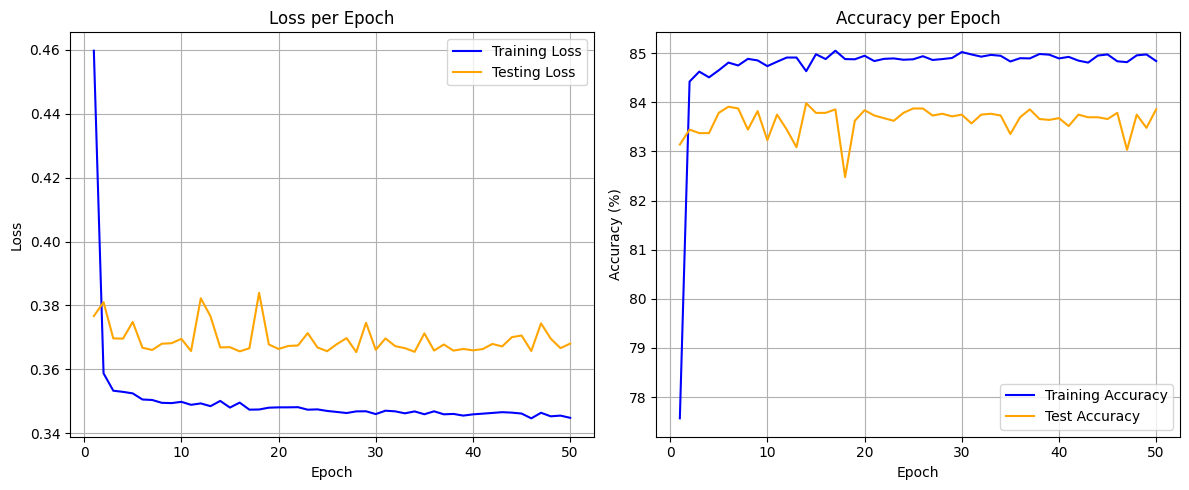

<Figure size 640x480 with 0 Axes>

In [41]:
model = SimpleNN()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate(model, train_loader, test_loader, loss_function, optimizer, num_epochs)

As expected, hits a pretty fixed accuracy quickly enough, with test accuracy a few percent below. Would probably overfit with enough epochs, trying that next.

Epoch [1/200] - Train Loss: 0.4041, Train Acc: 81.89% - Test Loss: 0.3755, Test Acc: 83.53%
Epoch [2/200] - Train Loss: 0.3585, Train Acc: 84.44% - Test Loss: 0.3772, Test Acc: 83.59%
Epoch [3/200] - Train Loss: 0.3551, Train Acc: 84.45% - Test Loss: 0.3693, Test Acc: 83.28%
Epoch [4/200] - Train Loss: 0.3518, Train Acc: 84.77% - Test Loss: 0.3716, Test Acc: 83.77%
Epoch [5/200] - Train Loss: 0.3519, Train Acc: 84.73% - Test Loss: 0.3844, Test Acc: 83.26%
Epoch [6/200] - Train Loss: 0.3563, Train Acc: 84.38% - Test Loss: 0.3688, Test Acc: 83.82%
Epoch [7/200] - Train Loss: 0.3527, Train Acc: 84.67% - Test Loss: 0.3669, Test Acc: 83.64%
Epoch [8/200] - Train Loss: 0.3505, Train Acc: 84.70% - Test Loss: 0.3701, Test Acc: 83.21%
Epoch [9/200] - Train Loss: 0.3531, Train Acc: 84.72% - Test Loss: 0.3816, Test Acc: 83.18%
Epoch [10/200] - Train Loss: 0.3511, Train Acc: 84.89% - Test Loss: 0.3681, Test Acc: 83.87%
Epoch [11/200] - Train Loss: 0.3518, Train Acc: 84.68% - Test Loss: 0.3665, Tes

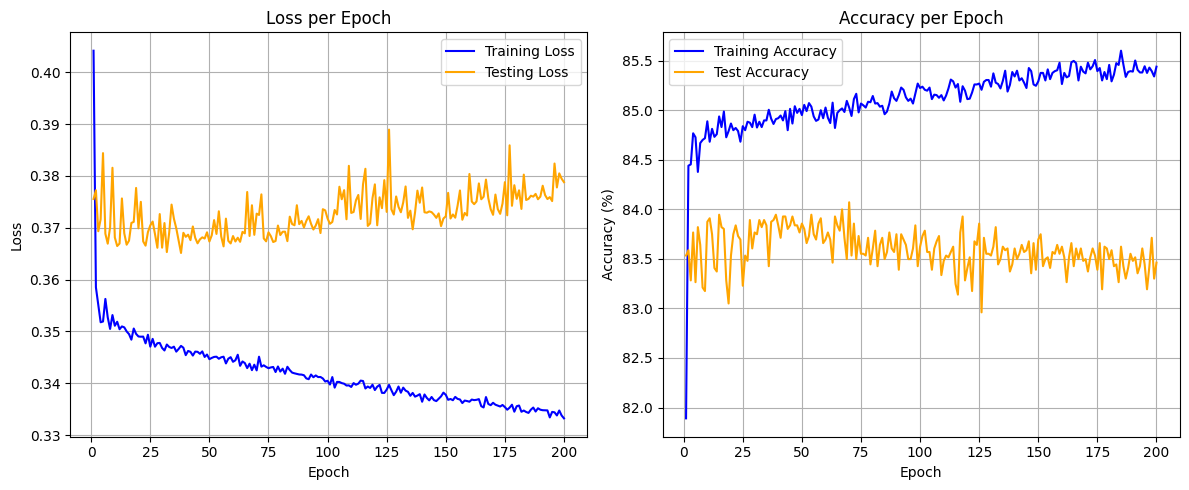

<Figure size 640x480 with 0 Axes>

In [42]:
model = SimpleNN()
loss_function = nn.BCELoss()
# also wanted to mess with the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.002)
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate(model, train_loader, test_loader, loss_function, optimizer, num_epochs)

Increasing the learning rate caused the curves to bounce around a lot more.
Didn't overfit as much as expected, but can still see the training and testing results moving apart over the epochs

#### Simple Network 2 (Only opinion columns)

Testing a similar network with only the columns where the students gave opinion scores (1-5). Want to see if removing (some) of the unrelated columns improves things

In [43]:
df_2 = df_1[['Academic Pressure', 'Study Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']]

df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Academic Pressure   27901 non-null  int64
 1   Study Satisfaction  27901 non-null  int64
 2   Work/Study Hours    27901 non-null  int64
 3   Financial Stress    27901 non-null  int64
 4   Depression          27901 non-null  bool 
dtypes: bool(1), int64(4)
memory usage: 899.3 KB


In [44]:
# just getting the basic numerical values for this one

X = df_2.iloc[:, 0:-1].values # get everything except for the last column, done the cleanup
y = df_2.iloc[:, -1].values   # only take the last one, since it has our label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

X_train = torch.tensor(X_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))


y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

X_train.size(1)

4

In [45]:
class SimpleNN2(nn.Module):
    def __init__(self):
        super(SimpleNN2, self).__init__()
        #even simpler network
        self.model = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
      return self.model(x)

Epoch [1/50] - Train Loss: 0.7145, Train Acc: 48.00% - Test Loss: 0.6186, Test Acc: 75.18%
Epoch [2/50] - Train Loss: 0.5557, Train Acc: 76.14% - Test Loss: 0.5160, Test Acc: 76.76%
Epoch [3/50] - Train Loss: 0.5041, Train Acc: 77.05% - Test Loss: 0.4953, Test Acc: 76.60%
Epoch [4/50] - Train Loss: 0.4900, Train Acc: 77.31% - Test Loss: 0.4849, Test Acc: 77.46%
Epoch [5/50] - Train Loss: 0.4871, Train Acc: 77.36% - Test Loss: 0.4807, Test Acc: 77.33%
Epoch [6/50] - Train Loss: 0.4840, Train Acc: 77.36% - Test Loss: 0.4846, Test Acc: 77.26%
Epoch [7/50] - Train Loss: 0.4829, Train Acc: 77.42% - Test Loss: 0.4785, Test Acc: 77.24%
Epoch [8/50] - Train Loss: 0.4827, Train Acc: 77.38% - Test Loss: 0.4779, Test Acc: 77.58%
Epoch [9/50] - Train Loss: 0.4824, Train Acc: 77.61% - Test Loss: 0.4787, Test Acc: 77.73%
Epoch [10/50] - Train Loss: 0.4821, Train Acc: 77.54% - Test Loss: 0.4894, Test Acc: 77.05%
Epoch [11/50] - Train Loss: 0.4821, Train Acc: 77.50% - Test Loss: 0.4776, Test Acc: 77.6

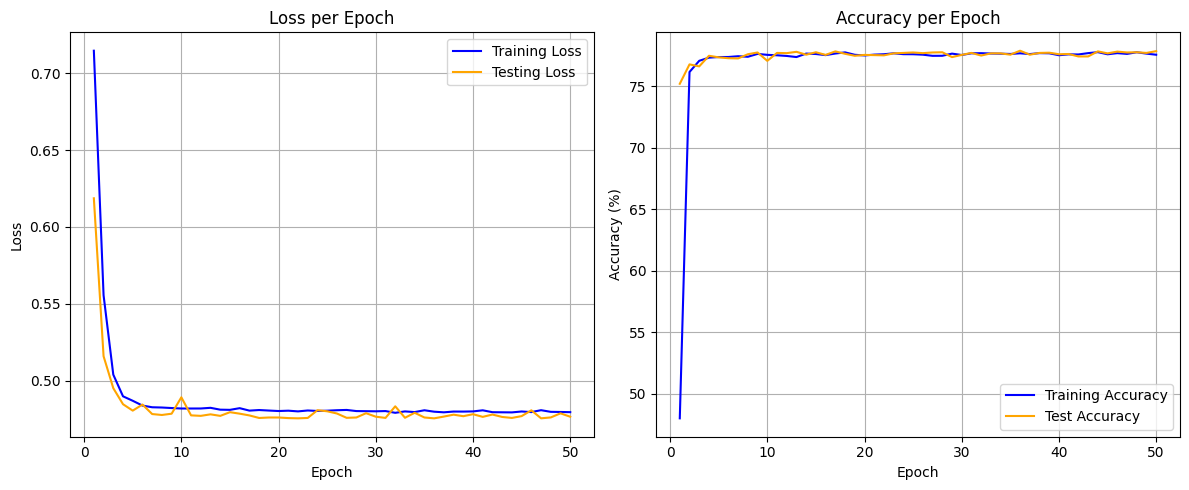

<Figure size 640x480 with 0 Axes>

In [46]:
model = SimpleNN2()
loss_function = nn.BCELoss()
# also changing the learning rate,
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate(model, train_loader, test_loader, loss_function, optimizer, num_epochs)

Somewhat confusing results. Lower overall accuracy, but test accuracy is bouncing around at roughly the same level as training accuracy. Possible that the opinion columns that aren't correlated are

Not sure what to make of higher accuracy for testing that happens sometimes?
Regardless, similar results compared to the less deep model

#### Simple Neural Network 3

Trying another model with just the correlated

### Model Testing (Wenxuan)

#### Dataset prep ####

Read in the dataset without numerical values, checking if those are correlated enough.
Rather than editing it each time, saved as its own file

In [53]:
uploaded = files.upload()
df_non = pd.read_csv("StudentDepressionDataset_NumbersOnly.csv")
print("Dataset shape:", df_non.shape)

Dataset shape: (27901, 10)


Check for NaN entries, and check how many rows have at least one

In [ ]:
# print(df_non.isnull().sum())  # Summarize how many NaNs in each column

# nan_rows = df_non[df_non.isnull().any(axis=1)]
# print("Rows with at least one NaN:")
# print(nan_rows)

Seperate out features & labels, everything except the last column

In [58]:
X = df_non.iloc[:, :-1].values
# the last column is Depression_Status
y = df_non.iloc[:, -1].values

# Make sure y is in float format for BCEWithLogitsLoss
y = y.astype(np.float32)

# Train-test split
# picked a different random state to check it
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

In [59]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Implementing a dataloader rather than _'s built in one

In [61]:
# Create Dataset & DataLoader
class StudentDepressionDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)  # note float for BCE

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# then run on our already split up data
train_dataset = StudentDepressionDataset(X_train, y_train)
test_dataset = StudentDepressionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Model Definition and evalution

Starting with the input features, and going down by 2 each layer, activating w/ ReLU each time

In [62]:
# Define a model
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 12)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(12, 8)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(8, 4)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(4, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.out(x)
        return x

Run the newly defined model, using a standard learning rate.

In [63]:
input_dim = X_train.shape[1]
model = FeedForwardNN(input_dim)

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Defining a test function w/ accumulators. Seeing how well it works over 200 epochs, which isn't small

In [64]:

num_epochs = 200
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)           # shape: [batch_size, 1]
        loss = criterion(outputs.squeeze(), batch_labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_features.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            logits = model(batch_features).squeeze()    # shape: [batch_size]

            # Convert logits to predictions: pred = sigmoid(logits) > 0.5
            preds = torch.sigmoid(logits)  # in range [0, 1]
            predicted_labels = (preds >= 0.5).float()    # 0.0 or 1.0

            total += batch_labels.size(0)
            correct += (predicted_labels == batch_labels).sum().item()

    test_accuracy = 100.0 * correct / total
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/200] Train Loss: 0.5387 | Test Accuracy: 78.50%
Epoch [2/200] Train Loss: 0.4605 | Test Accuracy: 78.57%
Epoch [3/200] Train Loss: 0.4589 | Test Accuracy: 78.70%
Epoch [4/200] Train Loss: 0.4581 | Test Accuracy: 78.91%
Epoch [5/200] Train Loss: 0.4575 | Test Accuracy: 78.82%
Epoch [6/200] Train Loss: 0.4575 | Test Accuracy: 78.84%
Epoch [7/200] Train Loss: 0.4571 | Test Accuracy: 79.04%
Epoch [8/200] Train Loss: 0.4568 | Test Accuracy: 79.04%
Epoch [9/200] Train Loss: 0.4566 | Test Accuracy: 79.02%
Epoch [10/200] Train Loss: 0.4564 | Test Accuracy: 79.07%
Epoch [11/200] Train Loss: 0.4565 | Test Accuracy: 79.20%
Epoch [12/200] Train Loss: 0.4563 | Test Accuracy: 79.13%
Epoch [13/200] Train Loss: 0.4563 | Test Accuracy: 79.23%
Epoch [14/200] Train Loss: 0.4564 | Test Accuracy: 79.11%
Epoch [15/200] Train Loss: 0.4560 | Test Accuracy: 79.09%
Epoch [16/200] Train Loss: 0.4558 | Test Accuracy: 79.18%
Epoch [17/200] Train Loss: 0.4558 | Test Accuracy: 79.07%
Epoch [18/200] Train Lo

#### Graph Plotting

Plot Accuracy & Training loss to see the results

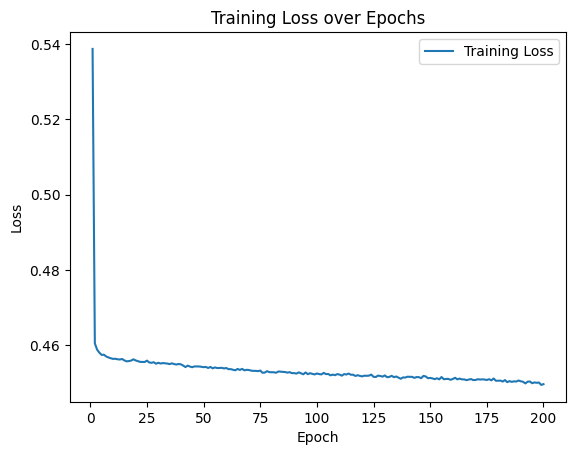

In [71]:
# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

As expected, training loss is steadily going down

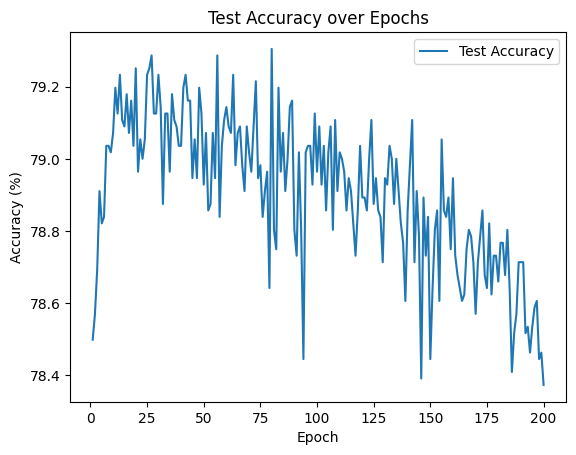

In [70]:
# Plot test accuracy
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.show()

Training accuracy is more sporadic, but it's generally going down over the epocs

### Model Testing (Gleb)

#### Dataset Examination/Cleanup

Take a look at the data (and the type of each column)

In [73]:
shape = df.shape
dtypes = df.dtypes
sample_rows = df.head()

shape, dtypes, sample_rows

((27901, 18),
 id                                         int64
 Gender                                    object
 Age                                      float64
 City                                      object
 Profession                                object
 Academic Pressure                        float64
 Work Pressure                            float64
 CGPA                                     float64
 Study Satisfaction                       float64
 Job Satisfaction                         float64
 Sleep Duration                            object
 Dietary Habits                            object
 Degree                                    object
 Have you ever had suicidal thoughts ?     object
 Work/Study Hours                         float64
 Financial Stress                         float64
 Family History of Mental Illness          object
 Depression                                 int64
 dtype: object,
    id  Gender   Age           City Profession  Academic Pressure  \
 

Doing some data cleaning first

In [75]:
# drop the id column
df_cleaned = df.drop(columns=["id"])

#fill the missing financial stress values
df_cleaned["Financial Stress"].fillna(df_cleaned["Financial Stress"].median(), inplace=True)

<ipython-input-75-1eb5b5a70d46>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["Financial Stress"].fillna(df_cleaned["Financial Stress"].median(), inplace=True)


Make a map to convert sleep duration into something the model can handle

In [76]:
sleep_map = {
    "Less than 5 hours": 4.5,
    "5-6 hours": 5.5,
    "7-8 hours": 7.5,
    "More than 8 hours": 9.0
}
df_cleaned["Sleep Duration"] = df_cleaned["Sleep Duration"].map(sleep_map)

Convert other non numerical values.
This loop goes through each column in the list of categorical columns. <br>
It uses `pd.factorize()` to convert string categories into integer codes
e.g., "Male", "Female" → 0, 1. <br>

In [77]:
factorize_mappings = {}

categorical_columns = [
    "Gender", "City", "Profession", "Dietary Habits", "Degree",
    "Have you ever had suicidal thoughts ?", "Family History of Mental Illness"
]

for col in categorical_columns:
    df_cleaned[col], uniques = pd.factorize(df_cleaned[col])  # convert to number
    factorize_mappings[col] = dict(enumerate(uniques)) # save to factorize map

factorize_mappings # display mappings

{'Gender': {0: 'Male', 1: 'Female'},
 'City': {0: 'Visakhapatnam',
  1: 'Bangalore',
  2: 'Srinagar',
  3: 'Varanasi',
  4: 'Jaipur',
  5: 'Pune',
  6: 'Thane',
  7: 'Chennai',
  8: 'Nagpur',
  9: 'Nashik',
  10: 'Vadodara',
  11: 'Kalyan',
  12: 'Rajkot',
  13: 'Ahmedabad',
  14: 'Kolkata',
  15: 'Mumbai',
  16: 'Lucknow',
  17: 'Indore',
  18: 'Surat',
  19: 'Ludhiana',
  20: 'Bhopal',
  21: 'Meerut',
  22: 'Agra',
  23: 'Ghaziabad',
  24: 'Hyderabad',
  25: 'Vasai-Virar',
  26: 'Kanpur',
  27: 'Patna',
  28: 'Faridabad',
  29: 'Delhi',
  30: 'Saanvi',
  31: 'M.Tech',
  32: 'Bhavna',
  33: 'Less Delhi',
  34: 'City',
  35: '3.0',
  36: 'Less than 5 Kalyan',
  37: 'Mira',
  38: 'Harsha',
  39: 'Vaanya',
  40: 'Gaurav',
  41: 'Harsh',
  42: 'Reyansh',
  43: 'Kibara',
  44: 'Rashi',
  45: 'ME',
  46: 'M.Com',
  47: 'Nalyan',
  48: 'Mihir',
  49: 'Nalini',
  50: 'Nandini',
  51: 'Khaziabad'},
 'Profession': {0: 'Student',
  1: 'Civil Engineer',
  2: 'Architect',
  3: 'UX/UI Designer',
  

As well, remove any null values, and scale the features, before finally splitting the dataset

In [78]:
df_cleaned = df_cleaned.dropna()

In [79]:
X = df_cleaned.drop(columns=["Depression"])
y = df_cleaned["Depression"]

In [80]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=567, stratify=y
)

#### Model Definition

Using tensorflow, check with the logistical regression model first

In [83]:
# initialize, then train model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# get predictions
y_pred = logreg.predict(X_test)

# get accuracy score by comparing predictions w/ labels
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8495606957145418


Trying gradient boost model next

In [84]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_gb))

Accuracy: 0.8517123901739286


Also checking a simple DL model

In [85]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate model
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

Accuracy: 0.8382642998027613


#### Model Testing & Plotting

Finally, setting up a simple DL model

In [86]:
model0 = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model0.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # equivalent to your test loop
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7544 - loss: 0.4884 - val_accuracy: 0.8420 - val_loss: 0.3637
Epoch 2/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8449 - loss: 0.3588 - val_accuracy: 0.8431 - val_loss: 0.3597
Epoch 3/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8458 - loss: 0.3513 - val_accuracy: 0.8438 - val_loss: 0.3598
Epoch 4/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8430 - loss: 0.3507 - val_accuracy: 0.8467 - val_loss: 0.3584
Epoch 5/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8492 - loss: 0.3442 - val_accuracy: 0.8465 - val_loss: 0.3574
Epoch 6/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8479 - loss: 0.3508 - val_accuracy: 0.8454 - val_loss: 0.3601
Epoch 7/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8477 - loss: 0.3490 - val_accuracy: 0.8463 - val_loss: 0.3594
Epoch 8/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8459 - loss: 0.3481 - val_accuracy: 0.

#### Plotting

Plot accuracy/loss for training and test sets

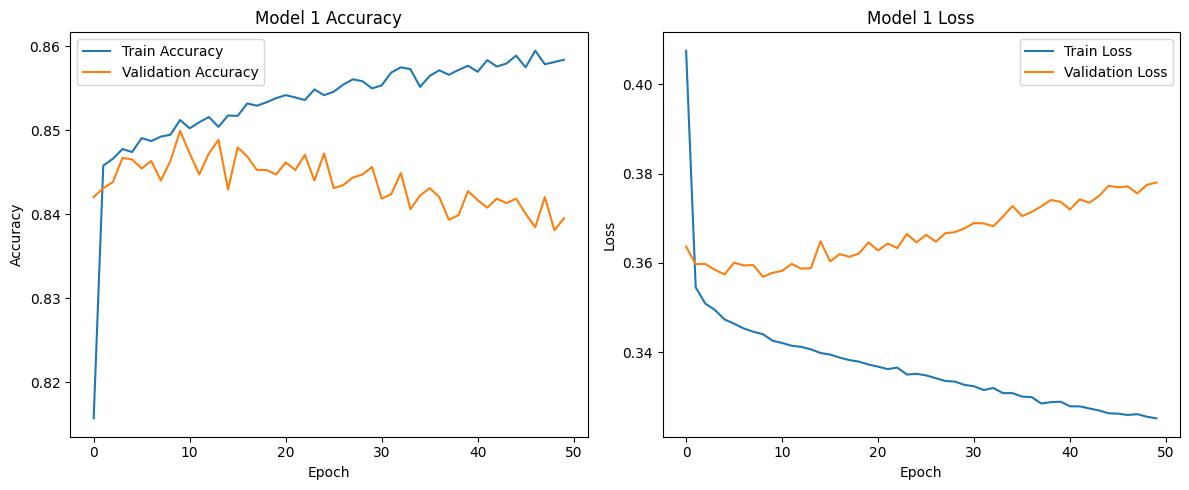

In [87]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
y_pred_probs = model0.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")
print(accuracy_score(y_test, y_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.8395194549040703


Trying again w/ a deeper model

In [89]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

In [90]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [91]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7774 - loss: 0.4573 - val_accuracy: 0.8445 - val_loss: 0.3576
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8469 - loss: 0.3483 - val_accuracy: 0.8456 - val_loss: 0.3526
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8515 - loss: 0.3426 - val_accuracy: 0.8454 - val_loss: 0.3550
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8510 - loss: 0.3415 - val_accuracy: 0.8442 - val_loss: 0.3545
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8529 - loss: 0.3424 - val_accuracy: 0.8427 - val_loss: 0.3552
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8527 - loss: 0.3469 - val_accuracy: 0.8427 - val_loss: 0.3546
Epoch 7/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8486 - loss: 0.3485 - val_accuracy: 0.8420 - val_loss: 0.3571
Epoch 8/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8541 - loss: 0.3372 - val_accuracy: 0.

Check it's accuracy as well:

In [92]:
y_pred_probs = model.predict(X_test)    # test
y_pred = (y_pred_probs > 0.5).astype("int32")
print(accuracy_score(y_test, y_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.8450779989241528


Then plot training/validation accuracy and loss values

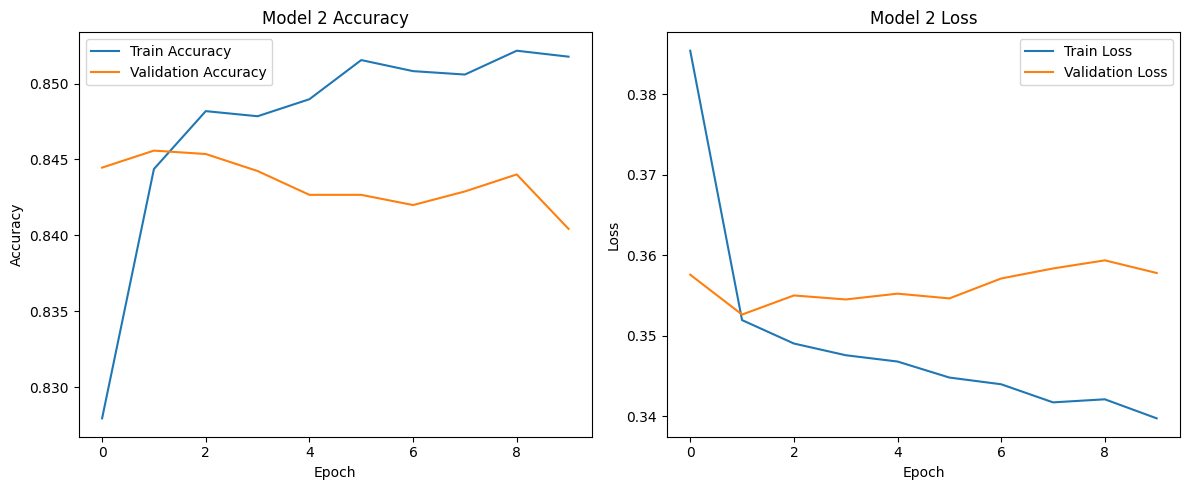

In [93]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



*   The model is learning and fitting the data
*   There isn't any real gain on the validation set
* Training Loss is decreasing, validation loss is bouncing around, but not improving
* Possibly some overfitting as well






Trying an even more complicated model next, with early stopping

In [94]:
model2 = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7476 - loss: 0.5184 - val_accuracy: 0.8458 - val_loss: 0.3498
Epoch 2/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8284 - loss: 0.3934 - val_accuracy: 0.8460 - val_loss: 0.3534
Epoch 3/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8421 - loss: 0.3760 - val_accuracy: 0.8489 - val_loss: 0.3526
Epoch 4/30
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8394 - loss: 0.3800 - val_accuracy: 0.8472 - val_loss: 0.3520


In [95]:
# getting the new model's accuracy as well
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")
print(accuracy_score(y_test, y_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
0.8450779989241528


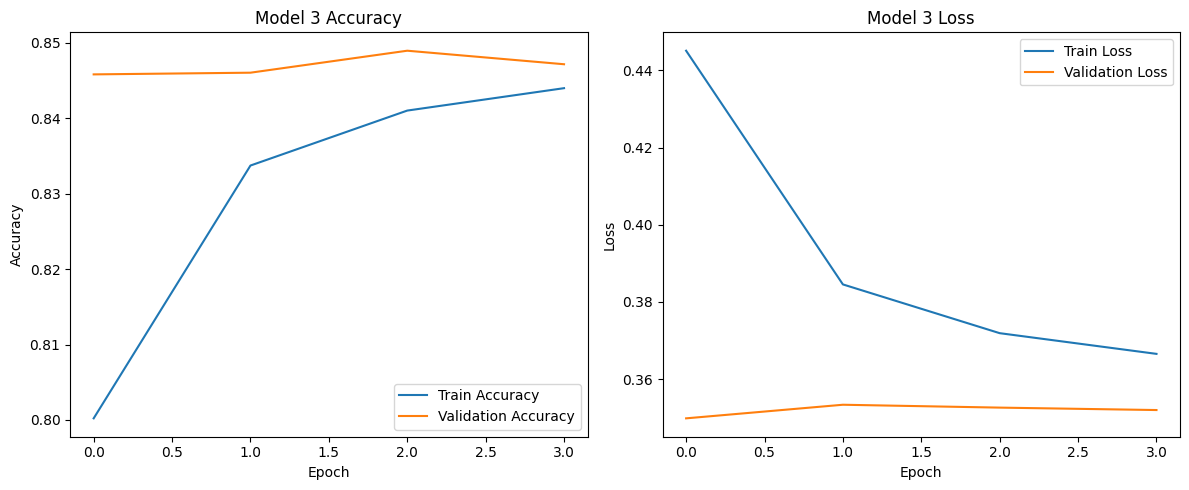

In [96]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 3 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 3 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Train accuracy starts 78% and climbs to 85.5% → nice upward trend. <br>
Validation ccuracy starts high (84.2%) and remains stable <br>

Train loss clearly decreases → model is optimizing well. <br>
Validation flat. <br>




#### Testing with Keras Tuner

Trying again with Keras Tuner, a library that automatically searches for a better architecture (number of layers, neurons per layer, dropout, learning rate, etc)

Defining a model-building function that Keras will call w/ different hyperparameters while testing different models

In [97]:
!pip install keras-tuner --quiet
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [98]:
def build_model(hp):
    model = models.Sequential() # seqeuntial model FNN
    model.add(layers.Input(shape=(X_train.shape[1],)))  # input layer

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 1, 3)):    #Number of layers: 1, 2, or 3 (randomly chosen)
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), #Units per layer: 32, 64, 96, or 128
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1))) #Dropout rate: Between 0.2 and 0.5 in 0.1 steps

    model.add(layers.Dense(1, activation='sigmoid')) # activation sigmoid

    # Tune learning rate
    lr = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001]) # learning rate choices

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),    #compile the model
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

Defining the tuner, which runs through different cominations (10 of them)

In [99]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Try 10 different combinations
    executions_per_trial=1,
    directory='kt_dir',
    project_name='depression_prediction'
)

Call the tuner to search throughout the models

In [100]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    X_train, y_train,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8458090424537659

Best val_accuracy So Far: 0.8491708040237427
Total elapsed time: 00h 04m 08s


After getting the best model from the search, print information on it

In [101]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

# Evaluate on test set
loss, acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters:
{'num_layers': 2, 'units_0': 96, 'dropout_0': 0.4, 'learning_rate': 0.0005, 'units_1': 96, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.2}
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8481 - loss: 0.3621
Test Accuracy: 0.8479


As well, display the results from the other trials the tuner ran:

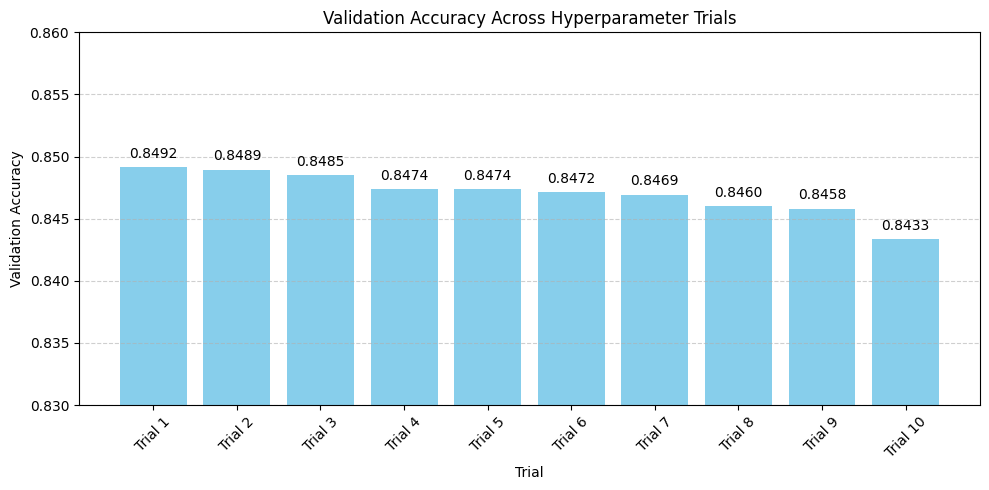

In [102]:
tuner_results = tuner.oracle.get_best_trials(num_trials=10)

# Extract validation accuracies
accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in tuner_results]
names = [f'Trial {i+1}' for i in range(len(tuner_results))]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(names, accuracies, color='skyblue')
plt.ylim(0.83, 0.86)  # Zoom in for more detail
plt.ylabel('Validation Accuracy')
plt.xlabel('Trial')
plt.title('Validation Accuracy Across Hyperparameter Trials')
plt.xticks(rotation=45)

# Add value labels above bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.0005, f"{acc:.4f}", ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Similar results over the tested different models, but they're all in a similar range, and the highest is still close in accuracy to the models above

#### ChatGPT Prompting (Gleb)

As well, giving an LLM the same information for a given student, and seeing what it's response is

#### Test Prompt

First, testing with just one prompt

In [ ]:
row = df.iloc[0] # get the first row

In [103]:
openai.api_key = "" # removed this for now, don't want to leave a publically available api key

Creating a prompt asking about that one student

In [ ]:
content = f"""
You are a mental health prediction model. Given the following data, your job is to classify them as either 1 for depressed or 0 for not depressed.

Here is the student information:
- Gender: {row['Gender']}
- Age: {row['Age']}
- City: {row['City']}
- Profession: {row['Profession']}
- Academic Pressure: {row['Academic Pressure']}
- Work Pressure: {row['Work Pressure']}
- CGPA: {row['CGPA']}
- Study Satisfaction: {row['Study Satisfaction']}
- Job Satisfaction: {row['Job Satisfaction']}
- Sleep Duration: {row['Sleep Duration']}
- Dietary Habits: {row['Dietary Habits']}
- Degree: {row['Degree']}
- Have they had suicidal thoughts before? {row['Have you ever had suicidal thoughts ?']}
- Work/Study Hours: {row['Work/Study Hours']}
- Financial Stress: {row['Financial Stress']}
- Family history of mental illness: {row['Family History of Mental Illness']}

Respond with only one word: either 1 or 0.
"""

In [ ]:
response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": content}],
    temperature=0.0
)  # get open AI response

Print the response we get (it's 1, so it's saying the student is depressed):

In [ ]:
print("Prediction:", response.choices[0].message.content.strip()) # Print response

Prediction: 1


Now lets using chatgpt to predict the first hundred rows.

#### Larger Scale Prompting

After that, let's try using ChatGPT to predict the first hundred rows in our dataset

In [ ]:
# get a response to our query from OpenAI
response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": content}],
    temperature=0.0
)  # get open AI response

Get response from repeated call to chatgpt
(Note: output originally from individually made notebook, didn't want to pay to run again)

In [ ]:
# Store predictions
gpt_preds = []

# Loop through the first 100 rows
for idx, row in df.head(100).iterrows():
    content = f"""
              You are a mental health prediction model. Given the following student's data, your job is to classify them as either 1 for depressed or 0 for not depressed.

              Here is the student information:
              - Gender: {row['Gender']}
              - Age: {row['Age']}
              - City: {row['City']}
              - Profession: {row['Profession']}
              - Academic Pressure: {row['Academic Pressure']}
              - Work Pressure: {row['Work Pressure']}
              - CGPA: {row['CGPA']}
              - Study Satisfaction: {row['Study Satisfaction']}
              - Job Satisfaction: {row['Job Satisfaction']}
              - Sleep Duration: {row['Sleep Duration']}
              - Dietary Habits: {row['Dietary Habits']}
              - Degree: {row['Degree']}
              - Have they had suicidal thoughts before? {row['Have you ever had suicidal thoughts ?']}
              - Work/Study Hours: {row['Work/Study Hours']}
              - Financial Stress: {row['Financial Stress']}
              - Family history of mental illness: {row['Family History of Mental Illness']}

              Respond with only one word: either 1 or 0.
              """
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": content}],
            temperature=0.0
        )
        prediction = response.choices[0].message.content.strip()
    except Exception as e:
        prediction = "error"
        print(f"Row {idx} failed: {e}")

    print(f"Row {idx} prediction: {prediction}")
    gpt_preds.append(prediction)

    time.sleep(1)  # avoid rate limits

Row 0 prediction: 1
Row 1 prediction: 1
Row 2 prediction: 1
Row 3 prediction: 1
Row 4 prediction: 1
Row 5 prediction: 1
Row 6 prediction: 0
Row 7 prediction: 1
Row 8 prediction: 1
Row 9 prediction: 1
Row 10 prediction: 1
Row 11 prediction: 1
Row 12 prediction: 1
Row 13 prediction: 1
Row 14 prediction: 1
Row 15 prediction: 1
Row 16 prediction: 1
Row 17 prediction: 1
Row 18 prediction: 0
Row 19 prediction: 0
Row 20 prediction: 1
Row 21 prediction: 0
Row 22 prediction: 1
Row 23 prediction: 0
Row 24 prediction: 1
Row 25 prediction: 0
Row 26 prediction: 1
Row 27 prediction: 1
Row 28 prediction: 1
Row 29 prediction: 1
Row 30 prediction: 1
Row 31 prediction: 1
Row 32 prediction: 1
Row 33 prediction: 0
Row 34 prediction: 0
Row 35 prediction: 1
Row 36 prediction: 1
Row 37 prediction: 1
Row 38 prediction: 0
Row 39 prediction: 1
Row 40 prediction: 1
Row 41 prediction: 1
Row 42 prediction: 1
Row 43 prediction: 1
Row 44 prediction: 0
Row 45 prediction: 0
Row 46 prediction: 1
Row 47 prediction: 1
Ro

#### Evaluation

Finally, let's compare our results with the actual predictions, and store the results in a dataframe

In [ ]:
# Compare with actual labels
actual = df.loc[:99, "Depression"].astype(str)

# Create a comparison DataFrame
results_df = pd.DataFrame({
    "Actual": actual,
    "GPT_Prediction": gpt_preds
})

# Filter out errors before computing accuracy
clean_df = results_df[results_df["GPT_Prediction"].isin(["0", "1"])]
len(clean_df["GPT_Prediction"])
accuracy = (clean_df["Actual"] == clean_df["GPT_Prediction"]).mean()

In [ ]:
print("Accuracy:", accuracy)
results_df.head(10)

Accuracy: 0.69


,Actual,GPT_Prediction
0,1,1
1,0,1
2,0,1
3,1,1
4,0,1
5,0,1
6,0,0
7,0,1
8,1,1
9,1,1


#### Llama Prompting (Alok)

Rather than using an api, opted to use ollama as a local server, and ask it using LangChain instead. <br>
Probably not the most efficient way to do this, but I also had it save externally so it can continue over multiple sessions

Partially based on on code from here:
https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb




In [104]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,697 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,847 kB]
Get:14

In [105]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)


In [106]:
!ollama pull llama3.2

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕▏  10 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕▏  24 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   2% ▕▏  46 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   4% ▕▏  75 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   4% ▕▏  90 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   6% ▕▏ 114 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   6% ▕▏ 124 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   7% ▕▏ 143 MB/

In [108]:
!pip install langchain-ollama

In [109]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from IPython.display import Markdown

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="llama3.2")
# change this to deepseek easily enough

chain = prompt | model


Seperated out the import statements, since some of them (above) take more time than the others

In [110]:
import pandas as pd
import os
from time import sleep
from google.colab import files

In [111]:
# read in a saved model predictions file first
uploaded = files.upload()

Saving llama_predictions.csv to llama_predictions.csv


In [112]:
df = pd.read_csv("Student Depression Dataset.csv")


In [124]:
question_list = []

# not taking all the information
# saw above that city, and job related columns aren't useful, not taking them

# just trying to ask the first few of them
question_amount = 150

for i in range(0,N):
    question = (f"""
You are a mental health prediction model. Given the following student's data, your job is to classify them as either 1 for depressed or 0 for not depressed.
- Gender: {df['Gender'].iloc[i]}
- Age: {df['Age'].iloc[i]}
- Academic Pressure: {df['Academic Pressure'].iloc[i]}
- CGPA: {df['CGPA'].iloc[i]}
- Study Satisfaction: {df['Study Satisfaction'].iloc[i]}
- Sleep Duration: {df['Sleep Duration'].iloc[i]}
- Dietary Habits: {df['Dietary Habits'].iloc[i]}
- Degree: {df['Degree'].iloc[i]}
- Have they had suicidal thoughts before? {df['Have you ever had suicidal thoughts ?'].iloc[i]}
- Work/Study Hours: {df['Work/Study Hours'].iloc[i]}
- Financial Stress: {df['Financial Stress'].iloc[i]}
- Family history of mental illness: {df['Family History of Mental Illness'].iloc[i]}
Please respond with only one word. Either 1 (for depressed), or 0 (for not depressed)
""")

    question_list.append(question)

print("Generated a list of questions for the model, the first", len(question_list), "of them")


Generated a list of questions for the model, the first 150 of them


In [114]:
output_file = "llama_predictions.csv"

In [119]:
# check if file has already been created/uploaded
if os.path.exists(output_file):
  print("predictions file does exist, loaded llama_predictions.csv")
  # if it does, copy it into a dataframe
  llama_results_df = pd.read_csv(output_file)
  print("starting from index", len(llama_results_df))
  # and use the length of the file to figure out what index to start from

else:
  # if not, it either hasn't been uploaded, or we're starting fresh
  llama_results_df = pd.DataFrame(columns=["Index" ,"Response"])
  # so put the index at 0
  print("no file found, starting from index 0")


predictions file does exist, loaded llama_predictions.csv
starting from index 71


Like above, make a list of questions for asking the model

In [120]:
# get a list of indexes it already asked about
existing_indices = set(llama_results_df["Index"].values)

print(existing_indices)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70)}


In [126]:
# run the model
for i in range(len(question_list)):
  # check if the current index has already been asked
  if i in llama_results_df["Index"].values:
    print(f"Skipping index {i}, already asked")
    continue

  print(f"Asking question for {i}")
  question = question_list[i]

  try:
      response = chain.invoke({"question": question})
  except Exception as e:
      response = "ERROR"


  # wish I could mark these as bools like another language
  contains_1 = "1" in response
  contains_0 = "0" in response

  # if the response doesn't have a 1 or (exclusively)
  if contains_1 ^ contains_0:
    status = "VALID"

  else:
    status = "INVALID"
    response = "ERROR"


  # add result to dataframe, then save it
  llama_results_df.loc[len(llama_results_df)] = [i, response]
  print(f"Saved response at index {i} to file, {status}")
  llama_results_df.to_csv(output_file, index=False)
  # not sure if waiting a bit helps, apparently it might prevent overloading?
  # sleep(0.5)





Skipping index 0, already asked
Skipping index 1, already asked
Skipping index 2, already asked
Skipping index 3, already asked
Skipping index 4, already asked
Skipping index 5, already asked
Skipping index 6, already asked
Skipping index 7, already asked
Skipping index 8, already asked
Skipping index 9, already asked
Skipping index 10, already asked
Skipping index 11, already asked
Skipping index 12, already asked
Skipping index 13, already asked
Skipping index 14, already asked
Skipping index 15, already asked
Skipping index 16, already asked
Skipping index 17, already asked
Skipping index 18, already asked
Skipping index 19, already asked
Skipping index 20, already asked
Skipping index 21, already asked
Skipping index 22, already asked
Skipping index 23, already asked
Skipping index 24, already asked
Skipping index 25, already asked
Skipping index 26, already asked
Skipping index 27, already asked
Skipping index 28, already asked
Skipping index 29, already asked
Skipping index 30, a

#### Llama Evaluation

Like with Gleb's section, get the corresponding labels from our dataset, and see how many match to get the accuracy

In [146]:
actual_labels = df.loc[:len(llama_results_df), "Depression"].astype(str)

results_df = pd.DataFrame({
    "actual_labels": actual_labels,
    "llama_prediction": llama_results_df['Response']
})

In [147]:
results_df.head()

,actual_labels,llama_prediction
0,1,1
1,0,1
2,0,1
3,1,ERROR
4,0,1


In [148]:
clean_df = results_df[results_df["llama_prediction"].isin(["0", "1"])]

In [154]:
len(clean_df["llama_prediction"])
accuracy = (clean_df["actual_labels"] == clean_df["llama_prediction"]).mean()
print("Accuracy:", accuracy)

Accuracy: 0.6821705426356589
